In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
sns.set_palette("colorblind")
from wordfreq import word_frequency
from surprisal_utils import exclude_token
from analysis_utils import run_crossval, format_logliks, fit_gam, plot_gam

# Data Preprocessing

In [2]:
df = pd.read_parquet("../results/dundee_evals_linear_0_512_new/metrics_autotpc.parquet")
df = df.drop("normed_gradient", axis=1)
df.head()

,free_energy,arclength,amplitude,li_top_down,li_bottom_up,wnorm_xy,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
0,374.976685,0.883823,4.948566,0.634650,0.648934,0.073766,0.258753,0.380693,0.180153,0.415627,0.098163,0.963429,0.626498,36.139664,352,the
1,375.123169,0.635727,5.140604,0.115113,0.774418,0.169816,0.261909,0.639637,0.439564,0.791606,0.431354,0.937455,0.330912,36.205719,329,renaissance
2,374.966248,0.541647,4.562534,0.158089,0.575466,0.037679,0.140286,0.363127,0.134553,0.304227,0.234576,0.928655,0.336979,36.136398,312,in
3,375.163574,0.552423,6.156165,-0.011823,0.988302,0.178486,0.190280,0.679504,0.497752,1.105536,0.650621,0.999389,0.247042,36.218872,305,childrens
4,375.078491,0.555392,3.805752,0.091203,0.615831,0.125969,0.215146,0.599986,0.358514,0.740043,0.469153,0.955290,0.265708,36.193436,304,literature


In [3]:
df_base = pd.read_csv("../results/dundee_base.csv")
df_base.head()

,token,RT,brown_bigram_surprisal,length,index
0,The,175.666667,0.918962,3,0
1,renaissance,396.400000,4.009531,11,1
2,in,163.250000,1.667814,2,2
3,children's,354.200000,5.507283,10,3
4,literature,235.700000,3.981875,10,4


In [4]:
#df = pd.read_csv("../results/dundee_metrics_linear_0_512_new.csv")
df = pd.concat([df_base, df], axis=1)
df.head()

,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,li_bottom_up,...,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
0,The,175.666667,0.918962,3,0,374.976685,0.883823,4.948566,0.634650,0.648934,...,0.258753,0.380693,0.180153,0.415627,0.098163,0.963429,0.626498,36.139664,352,the
1,renaissance,396.400000,4.009531,11,1,375.123169,0.635727,5.140604,0.115113,0.774418,...,0.261909,0.639637,0.439564,0.791606,0.431354,0.937455,0.330912,36.205719,329,renaissance
2,in,163.250000,1.667814,2,2,374.966248,0.541647,4.562534,0.158089,0.575466,...,0.140286,0.363127,0.134553,0.304227,0.234576,0.928655,0.336979,36.136398,312,in
3,children's,354.200000,5.507283,10,3,375.163574,0.552423,6.156165,-0.011823,0.988302,...,0.190280,0.679504,0.497752,1.105536,0.650621,0.999389,0.247042,36.218872,305,childrens
4,literature,235.700000,3.981875,10,4,375.078491,0.555392,3.805752,0.091203,0.615831,...,0.215146,0.599986,0.358514,0.740043,0.469153,0.955290,0.265708,36.193436,304,literature


In [5]:
df.columns

Index(['token', 'RT', 'brown_bigram_surprisal', 'length', 'index',
       'free_energy', 'arclength', 'amplitude', 'li_top_down', 'li_bottom_up',
       'wnorm_xy', 'wnorm_xx', 'bnorm_x', 'bnorm_y', 'cosdist_y',
       'cosdist_prior_v_posterior', 'cosdist_posterior_v_posterior',
       'cosdist_likelihood_v_posterior', 'bayesian_surprise', 'iters',
       'model_token'],
      dtype='object')

Merging with RNN surprisals

In [6]:
rnn_surprisals = pd.read_table("../results/dundee_lstm.tsv")
rnn_surprisals.rename({"surp" : "rnn_surprisal"}, axis = 1, inplace=True)
len(rnn_surprisals.index)

51502

The RNN surprisal is off by 1.

In [7]:
for i in range(len(rnn_surprisals.index)):
    if rnn_surprisals.iloc[i]['word'] != df.iloc[i]['token']:
        if rnn_surprisals.iloc[i]['word'] != "<unk>":
            print(i)
            break

23852


At Index 23852, the RNN has an extra token

In [8]:
rnn_surprisals.iloc[23850:23857]

,word,sentid,sentpos,wlen,rnn_surprisal,entropy,entred
23850,<unk>,1092,37,5,4.575858,8.602489,0.000000
23851,<unk>,1093,0,5,2.683529,5.634664,0.000000
23852,although,1093,1,8,13.280825,6.513316,0.000000
23853,she,1093,2,3,8.318652,6.678154,0.000000
23854,then,1093,3,4,8.467709,6.231436,0.446718
23855,qualifies,1093,4,9,16.167696,9.190198,0.000000
23856,this,1093,5,4,5.576224,3.375937,5.814261


In [9]:
df.iloc[23850:23857]

,token,RT,brown_bigram_surprisal,length,index,free_energy,arclength,amplitude,li_top_down,li_bottom_up,...,wnorm_xx,bnorm_x,bnorm_y,cosdist_y,cosdist_prior_v_posterior,cosdist_posterior_v_posterior,cosdist_likelihood_v_posterior,bayesian_surprise,iters,model_token
23850,"sorry!',",232.888889,3.093805,8,23850,375.068909,0.425612,3.944232,-0.014292,0.528396,...,0.141497,0.557330,0.366012,0.641014,0.536894,0.787510,0.258162,36.181091,291,sorry
23851,although,267.666667,4.698203,8,23851,374.984253,0.483302,4.643821,0.080944,0.655034,...,0.125439,0.399308,0.200588,0.299337,0.339853,0.975893,0.309118,36.143295,293,although
23852,she,219.400000,1.754821,3,23852,374.998901,0.427548,2.874565,0.041500,0.392592,...,0.117935,0.445249,0.224053,0.328787,0.369178,0.894154,0.186162,36.153000,302,she
23853,then,312.285714,3.409344,4,23853,374.988708,0.382176,2.228274,0.052978,0.264937,...,0.118615,0.413454,0.208270,0.283402,0.337478,0.714108,0.270889,36.146179,298,then
23854,qualifies,457.900000,5.819546,9,23854,375.123718,0.506991,4.914944,-0.027597,0.824953,...,0.182933,0.663201,0.423033,0.954881,0.686120,0.945990,0.230205,36.213394,292,qualifies
23855,this,225.000000,2.905638,4,23855,374.972961,0.506407,5.005449,0.137035,0.610289,...,0.121799,0.354819,0.185538,0.226240,0.249003,0.954522,0.347084,36.134918,301,this
23856,by,457.666667,2.690287,2,23856,374.998291,0.414243,3.275432,0.031783,0.423346,...,0.125564,0.468694,0.195502,0.445121,0.446191,0.808999,0.198594,36.158356,301,by


In [10]:
rnn_surprisals.drop(23851, inplace = True)

In [11]:
rnn_surprisals = rnn_surprisals.reset_index()
rnn_surprisals['index'] = rnn_surprisals['index'].apply(lambda index : index - 1 if index > 23851 else index)
df = df.merge(rnn_surprisals, on = "index")

Running the exclusion criteria

In [12]:
df['exclude'] = [exclude_token(df, i, 'token') for i in range(len(df.index))]

In [13]:
df['log_freq'] = -np.log2(df['word'].apply(word_frequency, lang = "en"))

/home/chiebuka/miniconda3/envs/plotting/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
pc_predictors = ['rnn_surprisal', 'brown_bigram_surprisal', 'iters', 'arclength',
 'li_bottom_up',
 'li_top_down',
 'free_energy',
 'wnorm_xy',
 'wnorm_xx',
 'cosdist_y',
 'cosdist_prior_v_posterior',
 'cosdist_likelihood_v_posterior',
 'bayesian_surprise']

df.rename({"length" : "word_length"}, axis = 1, inplace = True)

In [15]:
df = df[(df['exclude'] == 0)] # getting rid of exclusion criteria and NaNs
df = df.dropna()

In [16]:
len(df.index) # total number of tokens

31653

## Checking how to plot and fit GAMs using surprisal as an example

We now fit GAMs rather than linear models since we do not know if there is a linear relationship between the tPC predictors and RTs. We first check the relationship with surprisal. Standard units are plotted on the x-axis.

In [17]:
from pygam import GAM, s, te
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


Text(0, 0.5, 'Predicted RT')

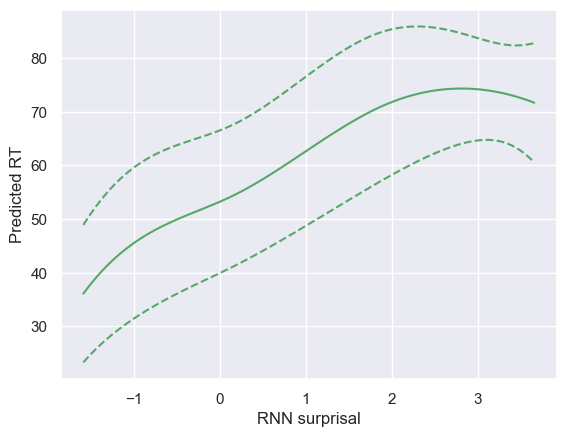

In [18]:
predictors = ['rnn_surprisal', 'log_freq', 'word_length']
# the features are based on the indices of the predictors
df.replace([np.inf, -np.inf], np.nan, inplace=True)
model_data = df[predictors + ['RT']].dropna()
standardscaler = StandardScaler()
X = standardscaler.fit_transform(np.array(model_data[predictors]))
y = np.array(model_data['RT'])

surprisal_gam = GAM(s(0, n_splines=6, spline_order=3) + te(1, 2, spline_order = 3))
surprisal_gam.fit(X, y)
XX = surprisal_gam.generate_X_grid(term=0)
pdep, confi = surprisal_gam.partial_dependence(term=0, X=XX, width=0.95)

plt.plot(XX[:, 0],  pdep, c = "g")
plt.plot(XX[:, 0], confi, c='g', ls='--')

plt.xlabel("RNN surprisal")
plt.ylabel("Predicted RT")

# Computing Predictive Power

We determine the training and test indices first so each regression model is evaluated on the same test data.

In [19]:
np.random.seed(84)

In [20]:
cv = KFold(n_splits=10, shuffle=True)
cv_split = cv.split(np.array(df))
indices = []
for train_indices, test_indices in cv_split:
    indices.append((train_indices, test_indices))


In [21]:
gam_ppp = run_crossval(indices, df, pc_predictors, 0, False) # does not include spillover effects for all predictors

Running 10-fold CV for rnn_surprisal
Average Delta LogLik: 0.0026575489257984588
Running 10-fold CV for brown_bigram_surprisal
Average Delta LogLik: 0.0013717358551725845
Running 10-fold CV for iters
Average Delta LogLik: 0.006534452201777441
Running 10-fold CV for arclength
Average Delta LogLik: 0.005370365009846001
Running 10-fold CV for li_bottom_up
Average Delta LogLik: 0.0017711963407230692
Running 10-fold CV for li_top_down
Average Delta LogLik: 0.002822216328104066
Running 10-fold CV for free_energy
Average Delta LogLik: 0.00014152337223496402
Running 10-fold CV for wnorm_xy
Average Delta LogLik: 4.684293642123194e-05
Running 10-fold CV for wnorm_xx
Average Delta LogLik: 0.0022272672715739185
Running 10-fold CV for cosdist_y
Average Delta LogLik: 0.003160988143369359
Running 10-fold CV for cosdist_prior_v_posterior
Average Delta LogLik: 0.0007087449615392316
Running 10-fold CV for cosdist_likelihood_v_posterior
Average Delta LogLik: 0.0016637350776710137
Running 10-fold CV for b

In [22]:
tpc_delta_loglik = pd.DataFrame(gam_ppp)
melted_loglik = format_logliks(tpc_delta_loglik)

Text(0.5, 1.0, 'Psychometric Predictive Power (Dundee)')

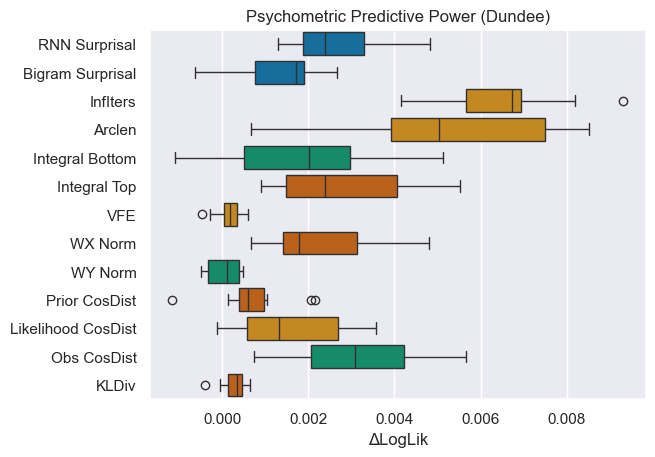

In [23]:
sns.boxplot(data = melted_loglik, x = "value", y = "predictor_name", hue = "metric_type", legend=False,
            order=["RNN Surprisal", "Bigram Surprisal",
                   "InfIters", "Arclen", "Integral Bottom", "Integral Top", "VFE", "WX Norm",
                   "WY Norm", "Prior CosDist", "Likelihood CosDist", "Obs CosDist", "KLDiv"])
plt.xlabel("ΔLogLik")
plt.ylabel("")
plt.title("Psychometric Predictive Power (Dundee)")

## Statistical Significance Testing

In [24]:
from analysis_utils import significance_table, compare_with_surprisal, significance_surprisal

First, we compute whether each tPC metric is a significant predictor of RT.

In [25]:
import scipy
def calc_p_value(loglik_data):
    wilcoxon_test = lambda predictor : scipy.stats.wilcoxon(loglik_data[predictor], np.zeros(10), alternative="greater")
    return [
        {predictor : predictor,
        "stat" : wilcoxon_test(predictor).statistic,
        "p_value" : wilcoxon_test(predictor).pvalue}
        for predictor in loglik_data.columns.values
    ]


For all predictors, everything is significantly above zero.

In [26]:
significance_table(tpc_delta_loglik)

,predictor_name,stat,p_value,significance
0,rnn_surprisal,55.0,0.000977,***
1,brown_bigram_surprisal,52.0,0.004883,**
2,iters,55.0,0.000977,***
3,arclength,55.0,0.000977,***
4,li_bottom_up,49.0,0.013672,*
5,li_top_down,55.0,0.000977,***
6,free_energy,40.0,0.116211,None
7,wnorm_xy,32.0,0.347656,None
8,wnorm_xx,55.0,0.000977,***
9,cosdist_y,55.0,0.000977,***


Finally, we compare the distributions of the predictive power for each tPC predictor with the surprisal's predictive power. This test determined if the predictive power associated with a predictor was over and above the predictive power of surprisal. Arc lengths are better than the RNN's surprisal, and top-down line integral and iteration count are better than bigram surprisal (and weight norm XX for the linear model).

In [27]:
tpc_predictors = pc_predictors[2:]
vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors,  "greater")

significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,55.0,0.000977,***
1,arclength,50.0,0.009766,**
2,li_bottom_up,14.0,0.919922,None
3,li_top_down,25.0,0.615234,None
4,free_energy,0.0,1.000000,None
5,wnorm_xy,0.0,1.000000,None
6,wnorm_xx,16.0,0.883789,None
7,cosdist_y,34.0,0.278320,None
8,cosdist_prior_v_posterior,1.0,0.999023,None
9,cosdist_likelihood_v_posterior,11.0,0.958008,None


In [28]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,55.0,0.000977,***
1,arclength,55.0,0.000977,***
2,li_bottom_up,34.0,0.278320,None
3,li_top_down,51.0,0.006836,**
4,free_energy,3.0,0.997070,None
5,wnorm_xy,4.0,0.995117,None
6,wnorm_xx,43.0,0.065430,None
7,cosdist_y,51.0,0.006836,**
8,cosdist_prior_v_posterior,10.0,0.967773,None
9,cosdist_likelihood_v_posterior,35.0,0.246094,None


This next set of tests looks at which predictors were comparable to surprisal: here, we are looking for a difference in the distributions of Psychometric Predictive Power that isn't statistically significant.

Arc length, top-down and bottom-up line integral, XX weight norms, and cosine distance-based predictors were all similar to RNN surprisal, and, weight norm, iteration, and cosine distance-based predictors were similar to bigram surprisal.

In [29]:
vs_bigram, vs_rnn = compare_with_surprisal(tpc_delta_loglik, tpc_predictors)

significance_surprisal(vs_rnn)

,predictor,gam_effect,gam_p,gam_significance
0,iters,0.0,0.001953,**
1,arclength,5.0,0.019531,*
2,li_bottom_up,14.0,0.193359,None
3,li_top_down,25.0,0.845703,None
4,free_energy,0.0,0.001953,**
5,wnorm_xy,0.0,0.001953,**
6,wnorm_xx,16.0,0.275391,None
7,cosdist_y,21.0,0.556641,None
8,cosdist_prior_v_posterior,1.0,0.003906,**
9,cosdist_likelihood_v_posterior,11.0,0.105469,None


In [30]:
significance_surprisal(vs_bigram)

,predictor,gam_effect,gam_p,gam_significance
0,iters,0.0,0.001953,**
1,arclength,0.0,0.001953,**
2,li_bottom_up,21.0,0.556641,None
3,li_top_down,4.0,0.013672,*
4,free_energy,3.0,0.009766,**
5,wnorm_xy,4.0,0.013672,*
6,wnorm_xx,12.0,0.130859,None
7,cosdist_y,4.0,0.013672,*
8,cosdist_prior_v_posterior,10.0,0.083984,None
9,cosdist_likelihood_v_posterior,20.0,0.492188,None


# Investigating the functional form of surprisal-like predictors

We investigate VFE (surprisal according to the tPC model) and ObsCosDist, the best observation-based predictor

Fitting model for free_energy
29.099199756137377
Fitting model for cosdist_y
29.665117372814898


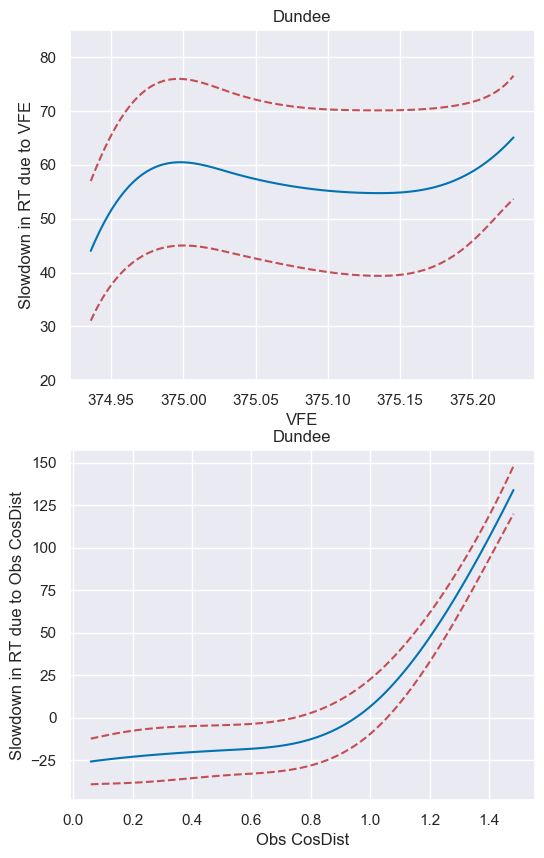

In [31]:
surprisal_like = ['free_energy', 'cosdist_y']
plot_labels = ["VFE", "Obs CosDist"]
bounds = [(20, 85), (None, None)]

fig, axs = plt.subplots(len(surprisal_like), figsize = (6, 10), sharex=False)
for i in range(len(surprisal_like)):
    predictor = surprisal_like[i]
    print(f"Fitting model for {predictor}")
    model = fit_gam(df, predictor, 0, False, False, False)
    plot_gam(model, df[predictor], plot_labels[i], axs[i], bounds[i], "Dundee")
